In [10]:
import argparse
import os
import re
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision.utils as vutils
from datasets import Places365Dataset, ViewDataSet3D
from completion import CompletionNet, Discriminator
from tensorboard import SummaryWriter
from datetime import datetime
import vision_utils
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

parser = argparse.ArgumentParser()
parser.add_argument('--dataroot', required=True, help='path to dataset')
parser.add_argument('--debug'  , action='store_true', help='debug mode')
parser.add_argument('--imgsize'  ,type=int, default = 256, help='image size')
parser.add_argument('--batchsize'  ,type=int, default = 1, help='batchsize')
parser.add_argument('--workers'  ,type=int, default = 6, help='number of workers')
parser.add_argument('--nepoch'  ,type=int, default = 50, help='number of epochs')
parser.add_argument('--lr', type=float, default=0.002, help='learning rate, default=0.002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--outf', type=str, default="filler", help='output folder')
parser.add_argument('--model', type=str, default="", help='model path')


opt = parser.parse_args(['--dataroot', '/data0/viewsyn_3d_26802/', '--model', 'filler_pano/compG_epoch2_30000.pth'])

def show_tensor(v):
    if isinstance(v,Variable):
        if v.is_cuda:
            t = v.cpu().data
        else:
            t = v.data
        plt.imshow(t.numpy().transpose(1,2,0))
    elif isinstance(v, torch.FloatTensor) or isinstance(v, torch.cuda.FloatTensor):
        if v.is_cuda:
            t = v.cpu()
        else:
            t = v
        plt.imshow(t.numpy().transpose(1,2,0))
    elif isinstance(v, np.ndarray):
        t = v
        if t.shape[0] == 1:
            t = t.transpose(1,2,0)
            t = t[:,:,0]
            plt.imshow(t)
        else:
            plt.imshow(t.transpose(1,2,0))

In [11]:
tf = transforms.Compose([
        vision_utils.RandomScale(opt.imgsize, int(opt.imgsize * 1.5)),
        transforms.RandomCrop((opt.imgsize, opt.imgsize * 2)),
        transforms.ToTensor(),
    ])

d = ViewDataSet3D(root = opt.dataroot, transform=tf, target_transform = tf, seqlen = 2, debug=True, off_3d = True)
cudnn.benchmark = True

Processing the data:
Total 2646 scenes 2381 train 265 test


 [Elapsed Time: 0:00:00] |#####                                | (ETA: 0:00:01) 

Indexing


 [Elapsed Time: 0:00:01] |####################################| (Time: 0:00:01) 


In [12]:
comp = CompletionNet()
comp = torch.nn.DataParallel(comp).cuda()
comp.load_state_dict(torch.load(opt.model))

In [13]:
comp = comp.module.cpu()

In [14]:
comp.eval()

CompletionNet (
  (convs): Sequential (
    (0): Conv2d(4, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): ReLU ()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): ReLU ()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU ()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (13): ReLU ()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (16): ReLU ()
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2,

In [58]:
def gen_mask():
    mask = np.zeros((1,256,512))
    for i in range(20):
        centerx = np.random.randint(64, 256-64)
        centery = np.random.randint(64, 512-64)
        width = np.random.randint(5,42)
        height = np.random.randint(5,42)
        mask[:, centerx - width:centerx + width, centery - height:centery+height] = 1
    return mask

def add_mask(img, mask, mean = np.array([ 0.45725039,  0.44777581,  0.4146058 ]).astype(np.float32)):
    img = img.numpy()
    img[:, mask[0,:,:] == 1] = np.expand_dims(mean, 1)
    img = torch.from_numpy(img.astype(np.float32))
    return img

In [103]:
data = d[15][0][0]
mask = gen_mask()
img = add_mask(data, mask)
mask = torch.from_numpy(mask.astype(np.float32))

In [104]:
imgv = Variable(img.unsqueeze(0))
maskv = Variable(mask.unsqueeze(0))

In [105]:
recon = comp(imgv, maskv)

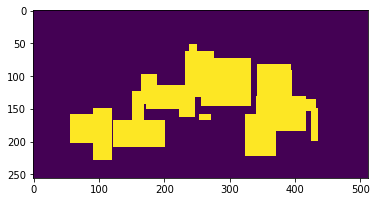

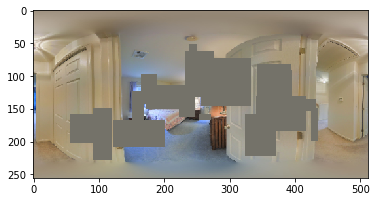

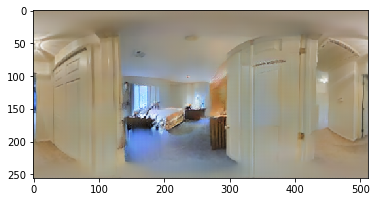

In [106]:
plt.figure()
show_tensor(mask.numpy())
plt.figure()
show_tensor(imgv[0])
plt.figure()
show_tensor(recon[0])